In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scvelo as scv
import scanpy as sc
import scvi
import torch
from velovi import VELOVI, preprocess_data

import warnings
warnings.filterwarnings('ignore')

# RNA Velocity Inference with veloVI

following the tutorial at https://velovi.readthedocs.io/en/latest/tutorial.html

## Data Loading

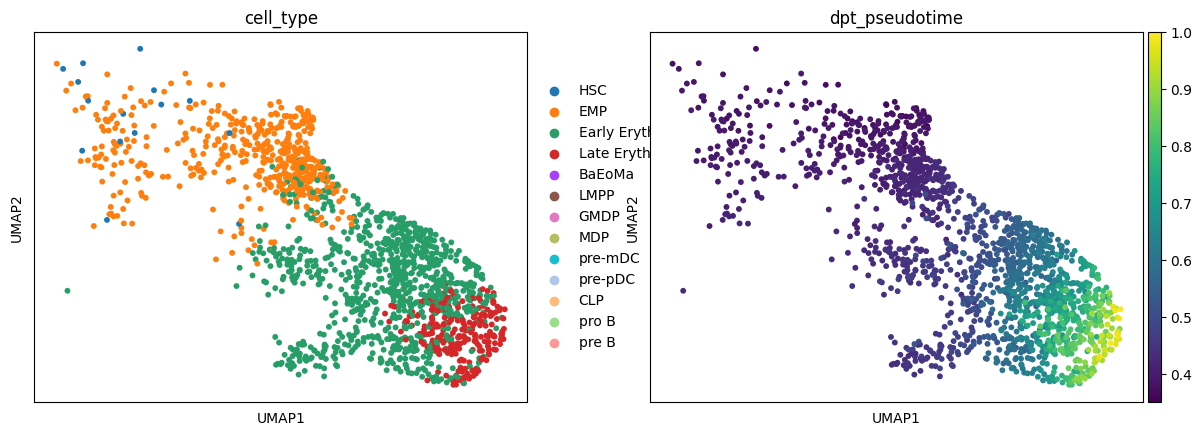

In [2]:
DATA_DIR = '/home/icb/sabrina.richter/git/scprotvelo/data/data_paired/'

adata = sc.read_h5ad(f"{DATA_DIR}/paired_adata_rna_eryth.h5ad")

sc.pl.umap(adata, color=['cell_type', 'dpt_pseudotime'])

## Preprocessing

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=20, n_neighbors=30, use_rep='X_totalVI')
adata = preprocess_data(adata)

Filtered out 28742 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.


/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.

Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Model Training

In [4]:
torch.manual_seed(0)
scvi.settings.seed = 0

VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-df8da9f3-c925-5d23-b3fa-2dacb31570f1]


Epoch 482/500:  96%|█████████▋| 482/500 [00:53<00:02,  8.95it/s, v_num=1, train_loss_step=-784, train_loss_epoch=-787]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -757.857. Signaling Trainer to stop.


## Evaluation

In [5]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
add_velovi_outputs_to_adata(adata, vae)

In [6]:
likelihoods = vae.get_gene_likelihood(
    adata=None,
    indices=None,
    gene_list=None,
    n_samples=1,
    batch_size=None,
    return_mean=True,
    return_numpy=None,
)

adata.var['likelihood'] = likelihoods.mean(axis=0)

In [7]:
adata.uns['cell_type_colors'] = ['#1f77b4', '#ff7f0e', '#8c564b', '#d62728']

computing velocity graph (using 1/128 cores)


/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


  0%|          | 0/1677 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


saving figure to file figures/stream_plot_rna.png


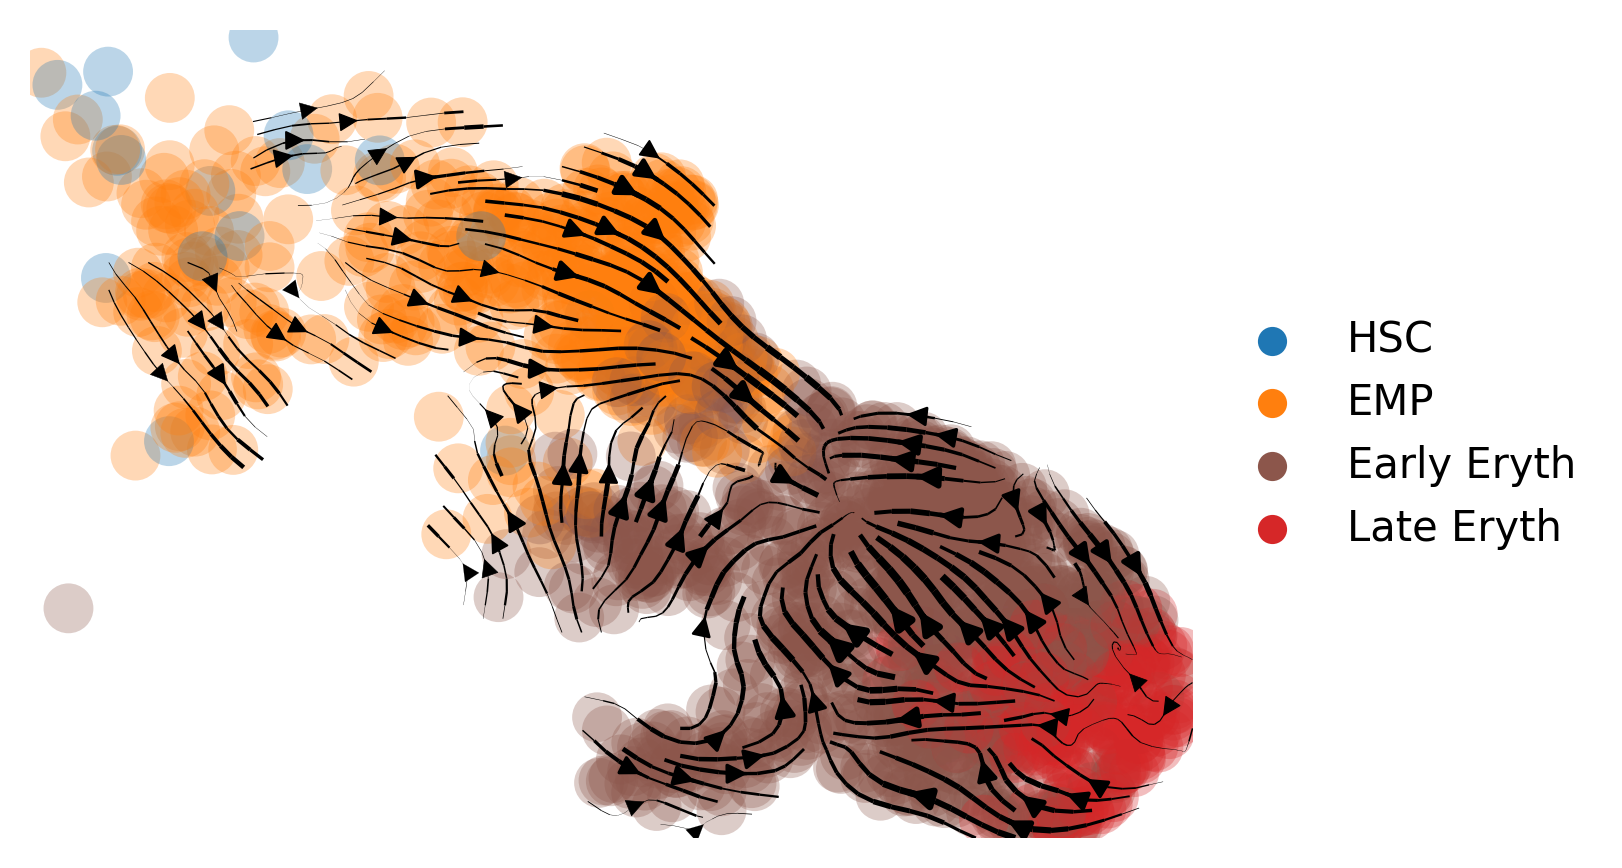

In [8]:
scv.tl.velocity_graph(adata, gene_subset=list(adata.var['likelihood'].sort_values()[-100:].index))
scv.pl.velocity_embedding_stream(
    adata, 
    color='cell_type', 
    basis='umap', 
    title='',
    save='figures/stream_plot_rna.png',
    dpi=300,
    figsize=(5, 3.5),
    legend_loc='right_margin',
)

/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


saving figure to file figures/paga_velovi.png


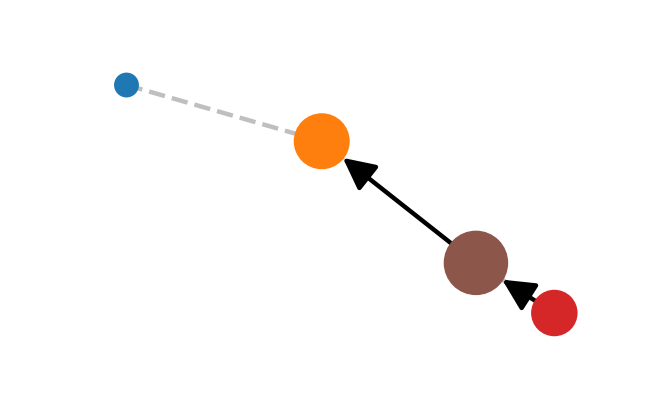

In [9]:
sc.set_figure_params(transparent=True)

scv.tl.paga(adata, groups="cell_type")
scv.pl.paga(
    adata, 
    basis="umap", 
    threshold=0.1,
    node_size_scale=3,
    arrowsize=30,
    legend_loc=None,
    size=0,
    save='figures/paga_velovi.png',
    figsize=(5, 3),
    title='',
)

/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


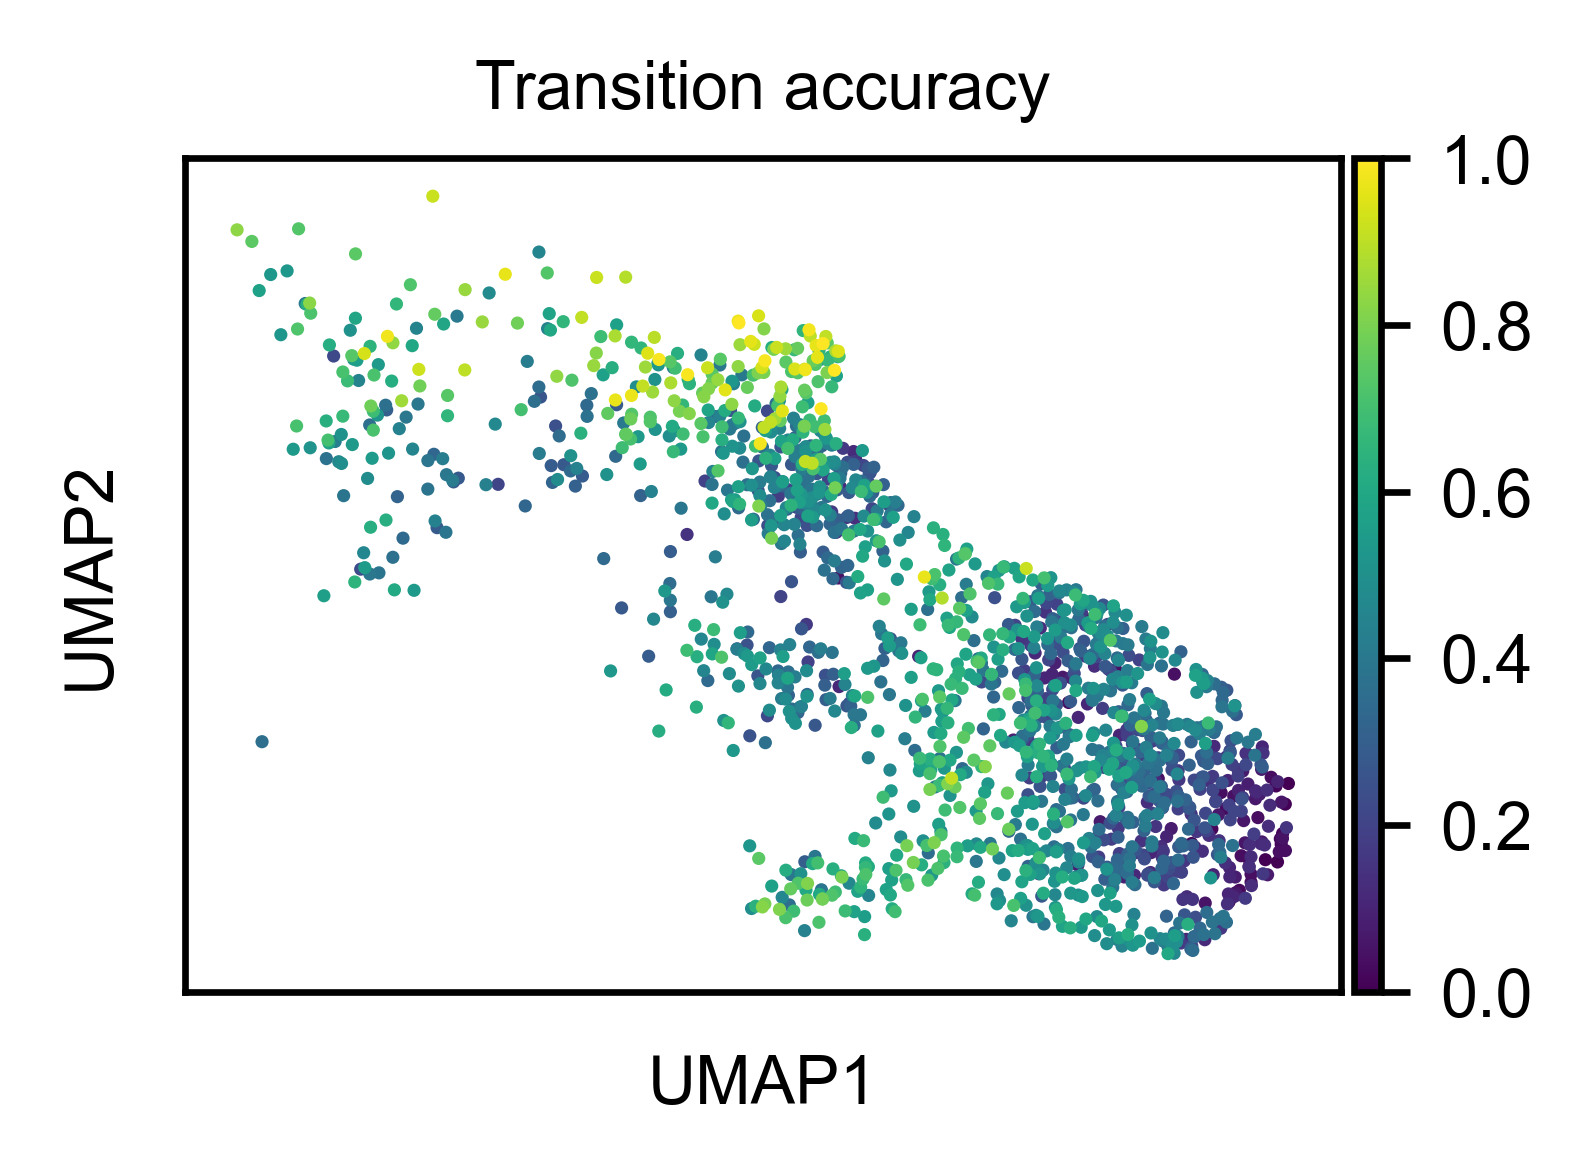

In [23]:
velocity_graph = adata.uns['velocity_graph'].toarray() # rows=cells, cols=neighbors, values: positive if cell moves towards neighbor
dpt_diff = (adata.obs['dpt_pseudotime'][:, None] - adata.obs['dpt_pseudotime'].values).T # positive entry: pseudotime in column cell is higher than pseudotime in row cell
dpt_diff[velocity_graph == 0] = np.nan

is_positive = (dpt_diff * velocity_graph) > 0  # change in pseudotime agrees with direction of movement
is_not_nan = (dpt_diff * velocity_graph) == (dpt_diff * velocity_graph)

positive_counts = is_positive.sum(axis=1)
not_nan_counts = is_not_nan.sum(axis=1)
fraction_positive = positive_counts / not_nan_counts

adata.obs['Transition accuracy'] = fraction_positive # fraction of neighbors in velocity graph where direction of change agrees with change in pseudotime

sc.set_figure_params(scanpy=True, fontsize=8, dpi=300)
with plt.rc_context({'font.family': 'Arial', 'figure.figsize': (2.7, 2)}):
    ax = sc.pl.umap(adata, color=['Transition accuracy'], vmin=0, vmax=1, s=10, show=False)
    plt.tight_layout()
    plt.savefig('figures/umap_accuracy_velovi.pdf', dpi=300)

## Comparison to scProtVelo Results

In [11]:
fraction_positive_scprotvelo = pd.read_csv('tmp/fraction_positive.csv', index_col=0, squeeze=True).values

/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


/home/icb/sabrina.richter/miniconda3/envs/scprotvelo/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


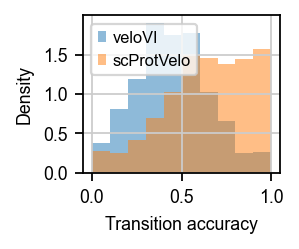

In [15]:
sc.set_figure_params(scanpy=True, fontsize=8)
with plt.rc_context({'font.family': 'Arial'}):
    plt.figure(figsize=(1.9, 1.6))
    plt.hist(fraction_positive, density=True, label='veloVI', alpha=.5)
    plt.hist(fraction_positive_scprotvelo, density=True, label='scProtVelo', alpha=.5)
    plt.xlabel('Transition accuracy')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/accuracy_histogram.pdf')
    plt.show()